In [1]:
import jax
import jax.numpy as jnp
from evosax import ParameterReshaper
import ipyplot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

# Setup

### Create environment

In [2]:
import gymnax as gym

In [3]:
env_name = "MountainCar-v0"
env, env_params = gym.make(env_name)
n_actions = env.action_space(env_params).n
obs_dims = env.observation_space(env_params).shape[0]

In [4]:
env_steps = env_params.max_steps_in_episode

### Create NDP and Policy

In [5]:
from models import HyperNCA, HyperNCA_Config
from policies import MLPPolicy

In [6]:
# MLP configuration
mlp_hidden_dims = max((obs_dims, n_actions)) # nb of features for each hidden layer
mlp_hidden_layers = 1 # nb of hidden layers
mlp_action_dims = n_actions 
mlp_obs_dims = obs_dims

In [7]:
policy = MLPPolicy(mlp_action_dims, mlp_hidden_layers,
                  mlp_hidden_dims, mode="categorical")
key = jax.random.PRNGKey(42)
policy_params = policy.init(key, jnp.zeros((obs_dims,)), key)
policy_params

FrozenDict({
    params: {
        mlp: {
            layers_0: {
                kernel: Array([[-0.0854697 , -0.42540255, -0.10164906],
                       [-0.11355377,  0.05332496, -1.1430653 ]], dtype=float32),
            },
            out_layer: {
                kernel: Array([[-0.68307227,  0.38337517, -0.16882634],
                       [-0.7283222 , -0.1463625 , -0.5922689 ],
                       [-0.16727802, -1.1538497 , -0.2005003 ]], dtype=float32),
            },
        },
    },
})

In [8]:
# NCA Configuration
channels = 4
alpha = 0.1 # alive threshold
perception_dims = 3 # nb of perception kernels
update_features = (16,) # hidden features of update network

iterations = 20 #number of development steps

In [9]:
ndp_config = HyperNCA_Config(
    channels = channels,
    alpha = alpha,
    perception_dims = perception_dims,
    update_features = update_features,
    iterations = iterations,
    action_dims = n_actions,
    obs_dims = obs_dims,
    hidden_dims = mlp_hidden_dims,
    hidden_layers = mlp_hidden_layers
)

In [10]:
ndp = HyperNCA(ndp_config)

In [11]:
z_dims = ndp.z_dims # nb of dimensions of the latent space (channels)
z_dims

4

In [12]:
ndp_params = ndp.init(jax.random.PRNGKey(42), jnp.ones((z_dims, )))
parameter_reshaper = ParameterReshaper(ndp_params)

ParameterReshaper: 580 parameters detected for optimization.


### Create evaluator

In [13]:
from evaluators import CompositionalityEvaluator, CompositionalityEvaluator_Config
from envs import bd_mountain_car

In [14]:
evaluator_config = CompositionalityEvaluator_Config(
    epochs = 1,
    env = env,
    env_params = env_params,
    env_steps = 200,
    n_params = z_dims,
    bd_extractor = bd_mountain_car,
    popsize = 128
)

In [15]:
evaluator = CompositionalityEvaluator(evaluator_config, ndp, policy)

### Create Trainer

In [16]:
from metandp import NDP_Trainer, Config

In [17]:
trainer_config = Config(
    epochs = 300,
    n_params = parameter_reshaper.total_params,
    params_shaper = parameter_reshaper,
    es = "des",
    popsize = 64,
    es_config = {},
    es_params = None
)

In [18]:
ndp_trainer = NDP_Trainer(trainer_config, ndp, evaluator)

# Train

In [19]:
key = jax.random.PRNGKey(42)
es_state, data = ndp_trainer.train(key)

	INNER LOOP #0
OUTER LOOP #0 : avg = 0.008823823183774948, top = 0.11121417582035065, best = -0.11121417582035065
	INNER LOOP #0
OUTER LOOP #1 : avg = 0.01577860862016678, top = 0.12087716162204742, best = -0.12087716162204742
	INNER LOOP #0
OUTER LOOP #2 : avg = 0.012917019426822662, top = 0.12122185528278351, best = -0.12122185528278351
	INNER LOOP #0
OUTER LOOP #3 : avg = 0.007157467305660248, top = 0.10408742725849152, best = -0.12122185528278351
	INNER LOOP #0
OUTER LOOP #4 : avg = 0.02125953510403633, top = 0.11926617473363876, best = -0.12122185528278351
	INNER LOOP #0
OUTER LOOP #5 : avg = 0.013065584003925323, top = 0.0873500183224678, best = -0.12122185528278351
	INNER LOOP #0
OUTER LOOP #6 : avg = 0.019390784204006195, top = 0.11154823750257492, best = -0.12122185528278351
	INNER LOOP #0
OUTER LOOP #7 : avg = 0.012156939134001732, top = 0.08744106441736221, best = -0.12122185528278351
	INNER LOOP #0
OUTER LOOP #8 : avg = 0.036133117973804474, top = 0.19130447506904602, best 

	INNER LOOP #0
OUTER LOOP #74 : avg = 0.38276153802871704, top = 0.6016972064971924, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #75 : avg = 0.4117524027824402, top = 0.660635232925415, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #76 : avg = 0.4018663167953491, top = 0.6554144620895386, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #77 : avg = 0.3810833692550659, top = 0.59117591381073, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #78 : avg = 0.3787711262702942, top = 0.641464114189148, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #79 : avg = 0.3977534770965576, top = 0.6674889326095581, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #80 : avg = 0.39054104685783386, top = 0.66100013256073, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #81 : avg = 0.35392147302627563, top = 0.6576617360115051, best = -0.6814082860946655
	INNER LOOP #0
OUTER LOOP #82 : avg = 0.37796443700790405, top = 0.6462889313697815, best = -0.6814082860946655
	IN

	INNER LOOP #0
OUTER LOOP #148 : avg = 0.4598972499370575, top = 0.6277084946632385, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #149 : avg = 0.45990848541259766, top = 0.6483794450759888, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #150 : avg = 0.46507778763771057, top = 0.6523524522781372, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #151 : avg = 0.4610427916049957, top = 0.6639786958694458, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #152 : avg = 0.442837119102478, top = 0.6535598635673523, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #153 : avg = 0.45326143503189087, top = 0.636377215385437, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #154 : avg = 0.46244698762893677, top = 0.6615049839019775, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #155 : avg = 0.446685254573822, top = 0.6484332084655762, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #156 : avg = 0.45499223470687866, top = 0.6459128856658936, best = -0.7255681

	INNER LOOP #0
OUTER LOOP #222 : avg = 0.5218803286552429, top = 0.659471869468689, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #223 : avg = 0.5106480121612549, top = 0.6376285552978516, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #224 : avg = 0.49027499556541443, top = 0.6699751615524292, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #225 : avg = 0.5283453464508057, top = 0.65880286693573, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #226 : avg = 0.5013908743858337, top = 0.6652610898017883, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #227 : avg = 0.5186761021614075, top = 0.6784120798110962, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #228 : avg = 0.49806490540504456, top = 0.6410583853721619, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #229 : avg = 0.5151854753494263, top = 0.6758399605751038, best = -0.7255681157112122
	INNER LOOP #0
OUTER LOOP #230 : avg = 0.5162632465362549, top = 0.6826767921447754, best = -0.7255681157

	INNER LOOP #0
OUTER LOOP #296 : avg = 0.5329869389533997, top = 0.6791254281997681, best = -0.7466869950294495
	INNER LOOP #0
OUTER LOOP #297 : avg = 0.5565361976623535, top = 0.6660957932472229, best = -0.7466869950294495
	INNER LOOP #0
OUTER LOOP #298 : avg = 0.5373315811157227, top = 0.6908146739006042, best = -0.7466869950294495
	INNER LOOP #0
OUTER LOOP #299 : avg = 0.5614064931869507, top = 0.6810031533241272, best = -0.7466869950294495


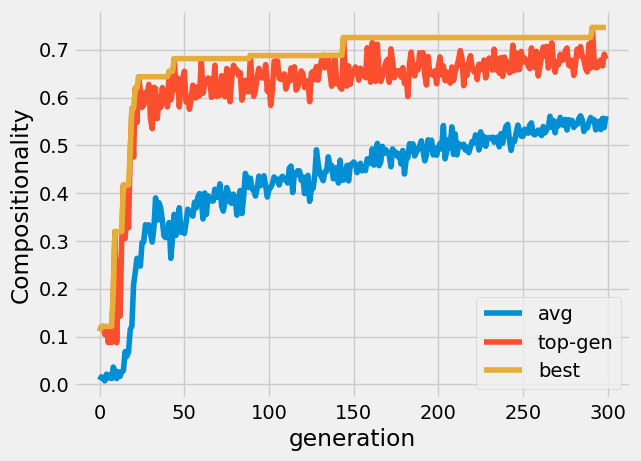

In [20]:
fitness = data['fitness']
avg_fitness = jnp.mean(fitness, axis=-1)
max_fitness = jnp.max(fitness, axis=-1)
best_fitness = -data['es_state'].best_fitness

plt.plot(avg_fitness, label='avg')
plt.plot(max_fitness, label='top-gen')
plt.plot(best_fitness, label='best')
plt.legend()
plt.xlabel('generation')
plt.ylabel('Compositionality')
plt.show()

In [21]:
best_params = es_state.best_member
best_params = parameter_reshaper.reshape(best_params[None, :])
best_params = jax.tree_map(lambda x: x[0], best_params)
test_key = jax.random.PRNGKey(66)
score, test_data = evaluator.test(test_key, best_params, n_samples=1000)
score

Array(0.5894691, dtype=float32)

In [22]:
bd = test_data['bd']
z = test_data['z']
bd.shape, z.shape

((1000, 2), (1000, 4))

In [23]:
df = pd.DataFrame()
for dim in range(z_dims):
    df[f'z_{dim}'] = z[:, dim]
df['bd_0'] = bd[:, 0]
df['bd_1'] = bd[:, 1]

In [42]:
from sklearn.cross_decomposition import PLSSVD, PLSCanonical, PLSRegression, CCA
from sklearn.decomposition import PCA

In [25]:
bd.shape, z.shape

((1000, 2), (1000, 4))

In [47]:
n_components = 2
mod = PLSSVD(n_components=2)
bdr, zr = mod.fit_transform(bd, z)
if n_components == 1:
    df["zr"] = zr
    df["bdr"] = bdr
else :
    df[[f"zr{i}" for i in range(n_components)]] = zr
    df[[f"bdr{i}" for i in range(n_components)]] = bdr

<Axes: xlabel='zr0', ylabel='zr1'>

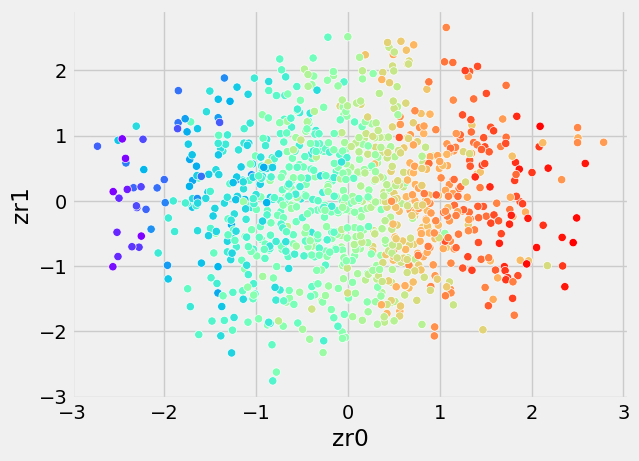

In [27]:
sns.scatterplot(data=df, x='zr0', y="zr1", hue="bdr0",
                legend=False, palette="rainbow")

<Axes: xlabel='bd_0', ylabel='bd_1'>

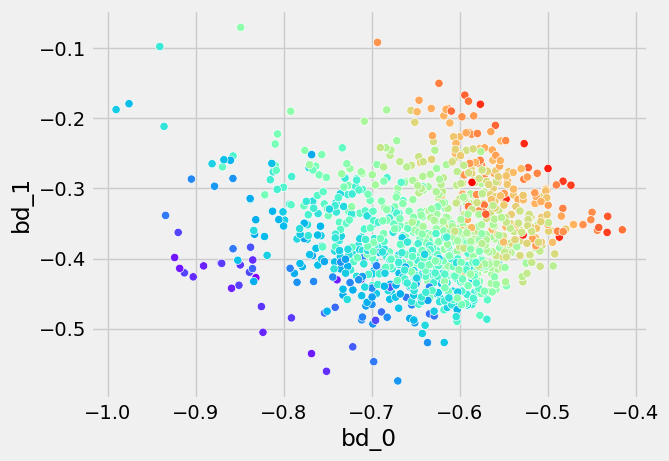

In [49]:
sns.scatterplot(data=df, x='bd_0', y="bd_1", hue="zr0",
                legend=False, palette="rainbow")

<Axes: xlabel='bd_0', ylabel='bd_1'>

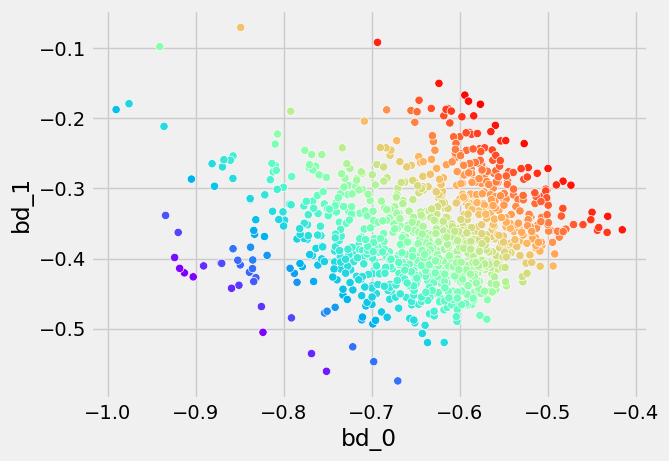

In [28]:
sns.scatterplot(data=df, x='bd_0', y="bd_1", hue="bdr0",
                legend=False, palette="rainbow")

In [29]:
# best_params = es_state.best_member
# best_params = parameter_reshaper.reshape(best_params[None, :])
# best_params = jax.tree_map(lambda x: x[0], best_params)
# test_key = jax.random.PRNGKey(66)
# fit, best_test_data = evaluator.test(test_key, best_params, n_samples=1000, 
#                                   render=False)
# bd_extractor = evaluator.config.bd_extractor
# bds_best = jax.vmap(bd_extractor)(best_test_data)

In [30]:
# worst_params = data['es_state'].best_member[0]
# worst_params = parameter_reshaper.reshape(worst_params[None, :])
# worst_params = jax.tree_map(lambda x: x[0], worst_params)
# test_key = jax.random.PRNGKey(66)
# fit, worst_test_data = evaluator.test(test_key, worst_params, n_samples=1000, 
#                                   render=False)
# bd_extractor = evaluator.config.bd_extractor
# bds_worst = jax.vmap(bd_extractor)(worst_test_data)

In [31]:
# s=20.
# plt.scatter(bds_best[:, 0], bds_best[:, 1], label='evolved NDP',
#            alpha = .3, s=s)
# plt.scatter(bds_worst[:, 0], bds_worst[:, 1], label='random NDP',
#            alpha=.3, s=s)
# plt.legend()
# plt.xlabel('min x')
# plt.ylabel('max x')
# plt.show()

# Eval

In [32]:
# from evaluators.simple_evaluator import SimpleEvaluator, SimpleEvaluator_Config

In [33]:
# opt_config = SimpleEvaluator_Config(
#     epochs = 200,
#     env = env,
#     env_params = env_params,
#     env_steps = 200,
#     mlp_hidden_dims = mlp_hidden_dims,
#     mlp_hidden_layers = mlp_hidden_layers,
#     n_params = z_dims,
#     es = "openes",
#     popsize = 128
# )

# opt = SimpleEvaluator(opt_config, ndp)

In [34]:
# key = jax.random.PRNGKey(33)
# best_fit, best_data = opt.eval(best_params, key)
# best_fit

In [35]:
# fitness = best_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

In [36]:
# worst_fit, worst_data = opt.eval(worst_params, key)

In [37]:
# fitness = worst_data['fitness']
# avg_fitness = jnp.mean(fitness, axis=-1)
# max_fitness = jnp.max(fitness, axis=-1)
# best_fitness = -best_data['es_state'].best_fitness

# plt.plot(avg_fitness, label='avg')
# plt.plot(max_fitness, label='top-gen')
# plt.plot(best_fitness, label='best')
# plt.legend()
# plt.xlabel('generation')
# plt.ylabel('fitness')
# plt.show()

# Visualize

In [38]:
# %%capture
# best_params = es_state.best_member
# best_params = parameter_reshaper.reshape(best_params[None, :])
# best_params = jax.tree_map(lambda x: x[0], best_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, best_params, n_samples=5, 
#                                   render=True, save_file="best")

In [39]:
# ipyplot.plot_images(files)

In [40]:
# %%capture
# worst_params = data['es_state'].best_member[0]
# worst_params = parameter_reshaper.reshape(worst_params[None, :])
# worst_params = jax.tree_map(lambda x: x[0], worst_params)
# test_key = jax.random.PRNGKey(66)
# fit, test_data, files = evaluator.test(test_key, worst_params, n_samples=5, 
#                                   render=True, save_file="best")

In [41]:
# ipyplot.plot_images(files)